# Quadgrid
The `quadgrid` package provides a class and some convenience functions 
for generating quadtree-based grids at arbitrary resolutions in pandas, geopandas and xarray formats for use in geospatial analysis and catastrophe risk modelling. 

## Overview
Quadtree grids are a way of recursively partitioning a plane into
nested quadrants, allowing for simple but efficient geocoding of
points.

Some assumptions have been made to simplify the package:
- all coordinates are in decimal degrees
- all longitudes range from -180 to +180 degrees
- the centre of the grid is at 0E, 0N

The package contains a single class, `QuadGrid`, which is used to
generate grid objects. The class has methods to convert the grid into
tabular (pandas DataFrame), vector (geopandas GeoDataFrame) and raster
(xarray Dataset) formats which can be saved or used in further processing.

Individual quadcells at a given resolution are labelled with unique
quadtreeIDs (qids). In the simplified example below, the red point is in top-level cell '2', then cell '2', then '0' then '3' giving a nominal qid of '2203'. In practice, quadtrees lend themselves to a base-4 encoding, allowing them to be stored and processed efficiently as integers.

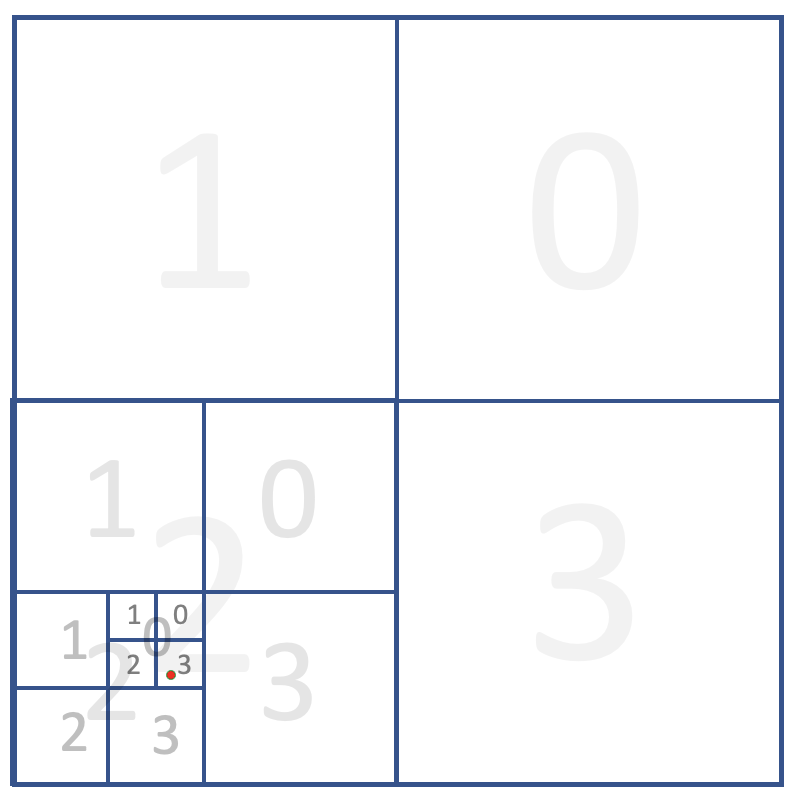

## Examples

In [1]:
import quadgrid as qg
import matplotlib.pyplot as plt
import geopandas as gpd

Load low resolution Natural Earth shapefiles from geopandas for demonstrations.

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_geom = world.dissolve().loc[0,'geometry']
uk_geom = world.set_index('iso_a3').loc['GBR','geometry']

### Global low-resolution grid

Create global quadgrid at 1.0$^{\circ}$ resolution:

In [3]:
q100_world = qg.QuadGrid(1)
q100_world

QuadGrid 1 deg | -180<=lon<=180 | -90<=lat<=90

Apply a shapely geometry object (either a Polygon or MultiPolygon) as a mask, in this case the dissolved country shapefile:

In [4]:
q100_world.apply_mask(world_geom)

In [5]:
q100_world_pd = q100_world.to_pandas()
q100_world_pd

qid        area   mask
lat   lon                              
-89.5 -179.5  161478  107.896473   True
      -178.5  161479  107.896473   True
      -177.5  161474  107.896473   True
      -176.5  161475  107.896473   True
      -175.5  161686  107.896473   True
...              ...         ...    ...
 89.5  175.5   56636  107.896473  False
       176.5   56425  107.896473  False
       177.5   56424  107.896473  False
       178.5   56429  107.896473  False
       179.5   56428  107.896473  False

[64800 rows x 3 columns]

In [6]:
q100_world_xr = q100_world.to_xarray()
q100_world_xr

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    qid      (lat, lon) int64 161478 161479 161474 161475 ... 56424 56429 56428
    area     (lat, lon) float64 107.9 107.9 107.9 107.9 ... 107.9 107.9 107.9
    mask     (lat, lon) bool True True True True ... False False False False
Attributes:
    Type:        quadgrid
    Resolution:  1 deg
    Area units:  km2

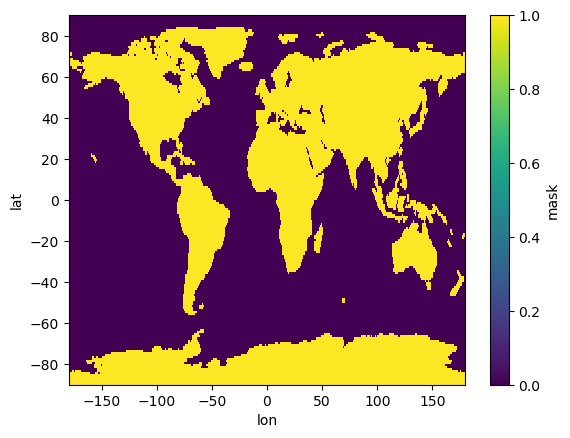

In [7]:
q100_world_xr['mask'].plot();

In [8]:
q100_world_gpd = q100_world.to_geopandas()
q100_world_gpd

,lat,lon,qid,area,mask,geometry
0,-89.5,-179.5,161478,107.896473,True,"POLYGON ((-179.00000 -89.00000, -179.00000 -90..."
1,-89.5,-178.5,161479,107.896473,True,"POLYGON ((-178.00000 -89.00000, -178.00000 -90..."
2,-89.5,-177.5,161474,107.896473,True,"POLYGON ((-177.00000 -89.00000, -177.00000 -90..."
3,-89.5,-176.5,161475,107.896473,True,"POLYGON ((-176.00000 -89.00000, -176.00000 -90..."
4,-89.5,-175.5,161686,107.896473,True,"POLYGON ((-175.00000 -89.00000, -175.00000 -90..."
...,...,...,...,...,...,...
64795,89.5,175.5,56636,107.896473,False,"POLYGON ((176.00000 90.00000, 176.00000 89.000..."
64796,89.5,176.5,56425,107.896473,False,"POLYGON ((177.00000 90.00000, 177.00000 89.000..."
64797,89.5,177.5,56424,107.896473,False,"POLYGON ((178.00000 90.00000, 178.00000 89.000..."
64798,89.5,178.5,56429,107.896473,False,"POLYGON ((179.00000 90.00000, 179.00000 89.000..."


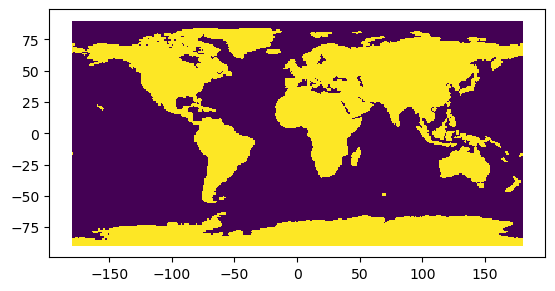

In [9]:
q100_world_gpd.plot(column='mask', cmap='viridis');

### UK medium-resolution grid

Make a regional grid over the UK at 0.25$^{\circ}$ resolution:

In [10]:
q25_UK = qg.QuadGrid(0.25, lon_bounds=(-10, 5), lat_bounds=(48, 60))
q25_UK

QuadGrid 0.25 deg | -10<=lon<=5 | 48<=lat<=60

Visualise the effect of applying a geometric mask with different buffering assumptions. The geometric mask is a simplified version of a spatial join, doing a fast point-in-polygon check for all grid centroids. In the left-hand plot (without buffering) we can see that there are areas within the geometry that don't have an associated quadcell. For those cells, this is because the centroid falls outside the geometry, even if some other part of the cell falls inside.

We can reduce this effect by buffering the geometry before doing the point-in-polygon check. A manual amount can be selected, or an optimal amount is automatically used if no `buff` argument is passed to `apply_mask`.

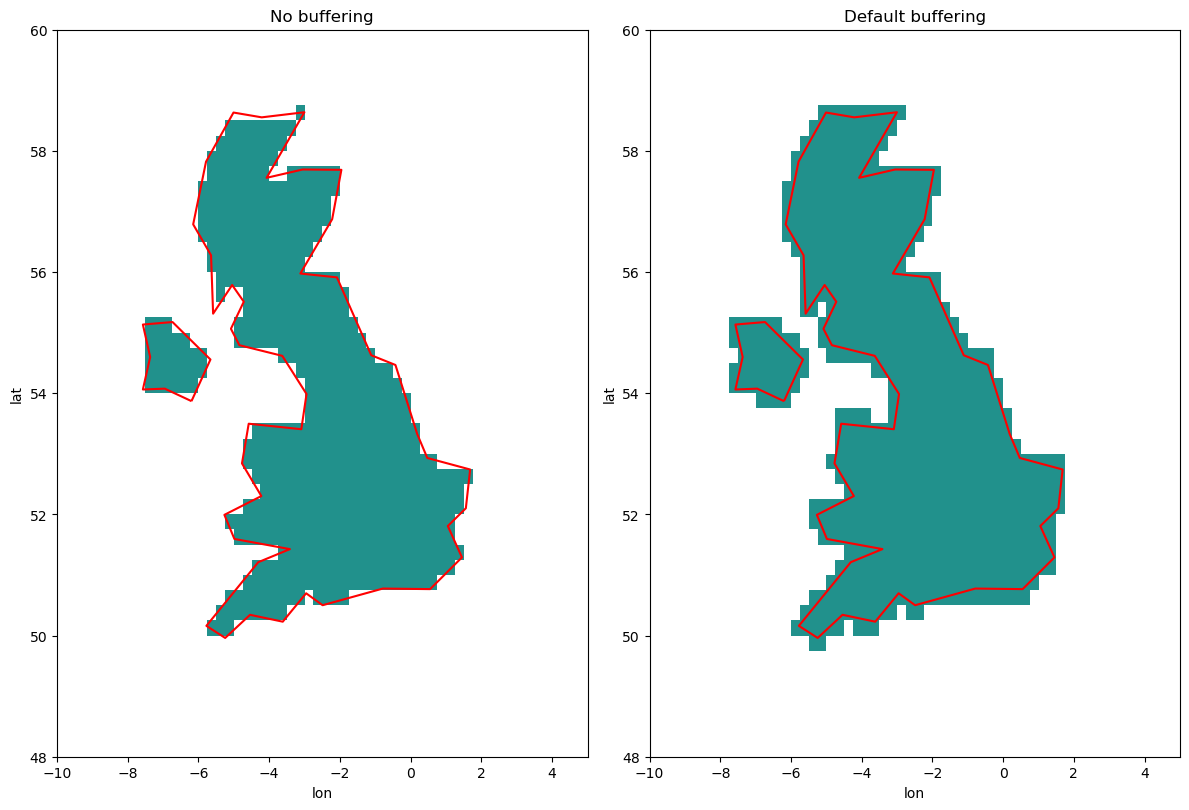

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,8))
q25_UK.apply_mask(uk_geom, buff=0)
q25_UK.to_xarray()['mask'].where(q25_UK.to_xarray()['mask']).plot(ax=ax1, add_colorbar=False)
world[world['iso_a3']=='GBR'].boundary.plot(ax=ax1, color='r')
ax1.set_title('No buffering')
q25_UK.apply_mask(uk_geom, buff=None)
q25_UK.to_xarray()['mask'].where(q25_UK.to_xarray()['mask']).plot(ax=ax2, add_colorbar=False)
world[world['iso_a3']=='GBR'].boundary.plot(ax=ax2, color='r')
ax2.set_title('Default buffering')
fig.tight_layout();

### Distance operations

The `distance()` method calculates the distances from a single point to all grid centroids. For example, the following calculates the distances from Greenwich Observatory of all quadcells on the UK subgrid.

In [12]:
dist = q25_UK.distance(-0.000546, 51.476855)
dist

lat     lon   
48.125  -9.875    799.804641
        -9.625    784.019025
        -9.375    768.324027
        -9.125    752.725496
        -8.875    737.229737
                     ...    
59.875   3.875    964.513949
         4.125    968.525482
         4.375    972.769271
         4.625    977.242235
         4.875    981.941186
Name: distance_km, Length: 2880, dtype: float64

Convert to xarray and use the xarray version of the UK mask to filter out non-land, then plot:

In [13]:
dist_da = dist.to_xarray()

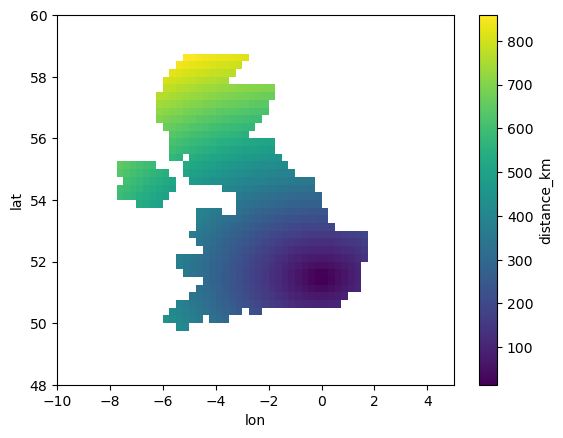

In [14]:
dist_da.where(q25_UK.to_xarray()['mask']).plot();